<a href="https://colab.research.google.com/github/Shakil-1501/TSAI/blob/master/S11/S11_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!nvidia-smi

Sat Jun 20 11:18:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from albumentations import Compose, Normalize, HorizontalFlip, VerticalFlip, Resize,Rotate , Cutout
from albumentations.pytorch import ToTensor
import numpy as np
import imgaug.augmenters as iaa
import torch.optim as optim
import time
import matplotlib.pyplot as plt

In [6]:
!git clone https://github.com/Shakil-1501/TSAI.git

fatal: destination path 'TSAI' already exists and is not an empty directory.


In [7]:
from TSAI.S11 import CustomResNet

In [8]:
from TSAI.S11 import LRScheduler

 LR Scheduler Loaded Successfully 


In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = CustomResNet.CustomResNet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

/content/TSAI/S11/CustomResNet.py:57: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [10]:
from TSAI.S11 import albumentationstransform

REQUIRED LIBRARIES LOADED...


In [11]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

trans = transforms.Compose([ transforms.ToTensor(),
                             transforms.Normalize(mean, std)
                            ]) 

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True, 
                                        transform = albumentationstransform.train_transforms() )
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=512,
                                          shuffle=True,
                                          num_workers=4, 
                                          pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=trans)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=512,
                                         shuffle=False, 
                                         num_workers=4, 
                                         pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [12]:
print(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

cuda


/content/TSAI/S11/CustomResNet.py:57: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Learning rate search finished. See the graph with {finder_name}.plot()


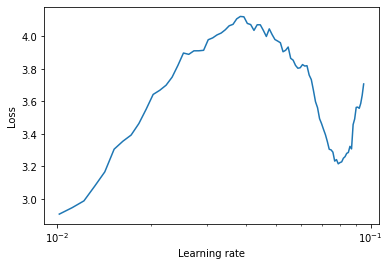

In [13]:
lr_finder = LRScheduler.LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader ,end_lr = 0.1, num_iter = 100 , step_mode = "linear")
lr_finder.plot()

In [13]:
print(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.95,weight_decay = 0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01,div_factor = 6 ,
                                                cycle_momentum = True , epochs=24, steps_per_epoch = len(trainloader),pct_start= 5/24,final_div_factor=1,anneal_strategy='linear')

cuda


In [14]:
start_time = time.time()
for epoch in range(24):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data[0].to(device),data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # print statistics
        running_loss += loss.item()
        if i % 90 == 89:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 89 ))
            running_loss = 0.0

print('Finished Training')
end_time = time.time()
print("Time Taken in Seconds: ",end_time-start_time)

/content/TSAI/S11/CustomResNet.py:57: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


[1,    90] loss: 1.726
[2,    90] loss: 1.122
[3,    90] loss: 0.888
[4,    90] loss: 0.738
[5,    90] loss: 0.625
[6,    90] loss: 0.557
[7,    90] loss: 0.480
[8,    90] loss: 0.435
[9,    90] loss: 0.394
[10,    90] loss: 0.355
[11,    90] loss: 0.331
[12,    90] loss: 0.307
[13,    90] loss: 0.286
[14,    90] loss: 0.262
[15,    90] loss: 0.253
[16,    90] loss: 0.233
[17,    90] loss: 0.223
[18,    90] loss: 0.205
[19,    90] loss: 0.189
[20,    90] loss: 0.183
[21,    90] loss: 0.172
[22,    90] loss: 0.158
[23,    90] loss: 0.147
[24,    90] loss: 0.135
Finished Training
Time Taken in Seconds:  454.1870572566986


In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

/content/TSAI/S11/CustomResNet.py:57: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Accuracy of the network on the 10000 test images: 90 %
